# CASA Summary
The pipeline used for calibration and flagging closely follows that of the CASA pipeline (https://casaguides.nrao.edu/index.php?title=VLA-S-CASA_Pipeline-CASA6.2.1#Stage_7._hifv_checkflag:_Flag_possible_RFI_on_BP_calibrator_using_rflag). This notebook summarises the output of the pipeline (calibration tables, flagging summaries, data plots) and can be used to get an overview of the data and identify bad data that needs to be flagged manually.

In [1]:
import os
import sys
import h5py
import yaml
import casatasks
import numpy as np
from astropy.time import Time
import astropy.units as u
from ipywidgets import interact

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.viridis  
cmap.set_bad(color='red')

from IPython.display import Image

# read yaml file
with open("../input/config.yaml", "r") as file:
    conf = yaml.safe_load(file)
    
sys.path.append(os.path.join(os.curdir, "../"))

from vlapy import vladata, inspect

## Obervation Information 
The data below is the output of CASA's listobs task and can be used to fill in the yaml file "obs.yaml", which contains all the parameters for the pipeline.

In [2]:
obs = conf["obs list"][4]
root = os.path.join(conf["root"], f"{obs}")
name = obs.split(".")[0]

ms = os.path.join(root, f"{obs}_hanning.ms")
vladata.listobs(ms)

BeginTime
58739.626967592594 

EndTime
58739.73699074074 

IntegrationTime
9506.0 

field_0
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 1.4948845339}, 'm1': {'unit': 'rad', 'value': 0.8700817014000001}, 'refer': 'J2000', 'type': 'direction'}
name :  3C147


field_1
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.2780251331}, 'm1': {'unit': 'rad', 'value': 0.3245390807}, 'refer': 'J2000', 'type': 'direction'}
name :  J0842+1835


field_10
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.3523540386}, 'm1': {'unit': 'rad', 'value': 0.0066705514}, 'refer': 'J2000', 'type': 'direction'}
name :  QSO J0859+0022


field_11
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.3689113955}, 'm1': {'unit': 'rad', 'value': 0.0335049887}, 'refer': 'J2000', 'type': 'direction'}
name :  QSO J0902+0155


field_12
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.3812581455}, 'm1': {'unit': 'rad', 'value': 0.052644948000000004}, 'refer': 'J2000', 'ty

### Array Layout

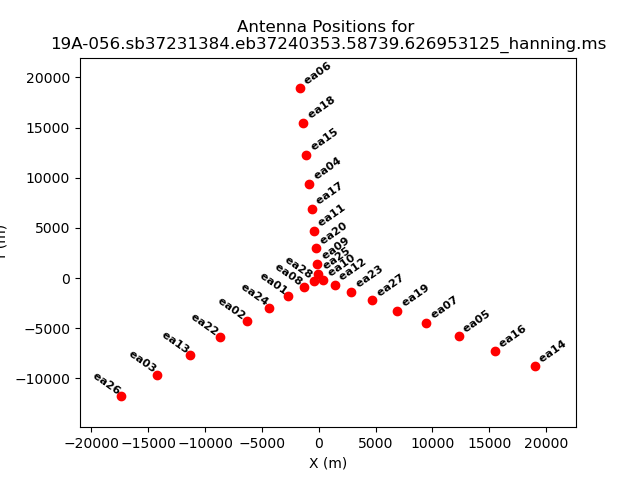

In [3]:
Image(filename=root + "/plots/obsplots/antlayout.png")

### Plot Elevation vs. Time
Observations low in elevation might see more RFI. The plot is colorised by field. Each target field is in between two phase calibrators.

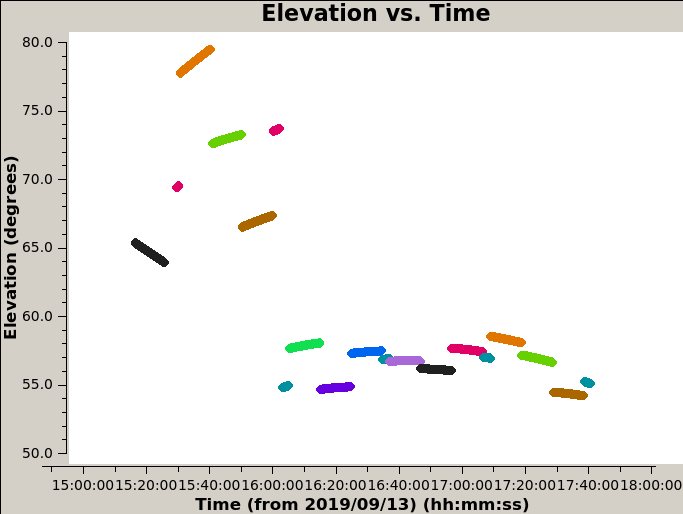

In [4]:
Image(filename=root + "/plots/obsplots/elevation_vs_time.png")

## VLA Deterministic Flags and Manual Flags
These include antennas not on source, shadowed antennas, scans with non-relevant intents, autocorrelations, edge channels of spectral windows, edge channels of the baseband, clipping absolute zero values produced by the correlator and the first few integrations of a scan (quacking). Manual flags are also applied for data known to be bad (RFI, obs reports). Below is a summary of the flags before and after applying the deterministic flags. Use the flagging frequency to find a suitable reference antenna and specify it in the yaml file.

In [5]:
summary_before = np.load(root + "/output/detflag_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/detflag_summary_after.npy", allow_pickle='TRUE').item()

# print flagging summary
def print_summary(item):
    for subitem in summary_before[item]:
        print(f"{item} {subitem}")
        print(
            "Before: {:.4f}, After: {:.4f}".format(
                100.0 * summary_before[item][subitem]["flagged"] / summary_before[item][subitem]["total"],
                100.0 * summary_after[item][subitem]["flagged"] / summary_after[item][subitem]["total"],
            )
        )
        print("")
        
print("Flag occupancy (percent) before and after deterministic flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after deterministic flags:

field 3C147
Before: 36.6571, After: 43.5329

field J0842+1835
Before: 63.4616, After: 67.1141

field J0909+0121
Before: 19.6942, After: 27.6915

field QSO J0818+1722
Before: 10.8541, After: 19.7352

field QSO J0828+2633
Before: 6.7169, After: 15.9675

field QSO J0842+1218
Before: 13.8976, After: 22.7474

field QSO J0844+0226
Before: 5.8458, After: 15.6469

field QSO J0844-0052
Before: 5.1600, After: 14.5705

field QSO J0853+0139
Before: 11.4607, After: 20.3445

field QSO J0857+0056
Before: 4.5963, After: 14.0584

field QSO J0859+0022
Before: 3.5649, After: 13.6071

field QSO J0902+0155
Before: 4.0846, After: 13.6183

field QSO J0905+0300
Before: 4.0655, After: 13.6006

field QSO J0911+0152
Before: 4.0914, After: 13.6017

field QSO J0935-0110
Before: 6.0502, After: 15.3677

scan 1
Before: 100.0000, After: 100.0000

scan 10
Before: 5.8458, After: 15.6469

scan 11
Before: 5.1600, After: 14.5705

scan 12
Before: 11.4607, After

### Plot Online Flags
Plot flaggingreason vs. time. This shows which antennas are flagged due to focus errors, subreflector errors and antenna not on source. This plot can help identify suitable reference antennas.

In [6]:
if os.path.exists(root+"/plots/dataplots/flaggingreason_vs_time.png"):
    Image(filename=root+"/plots/dataplots/flaggingreason_vs_time.png")

### Plot Antenna Data Stream
If an antenna has missing data, it should not be used as a reference.

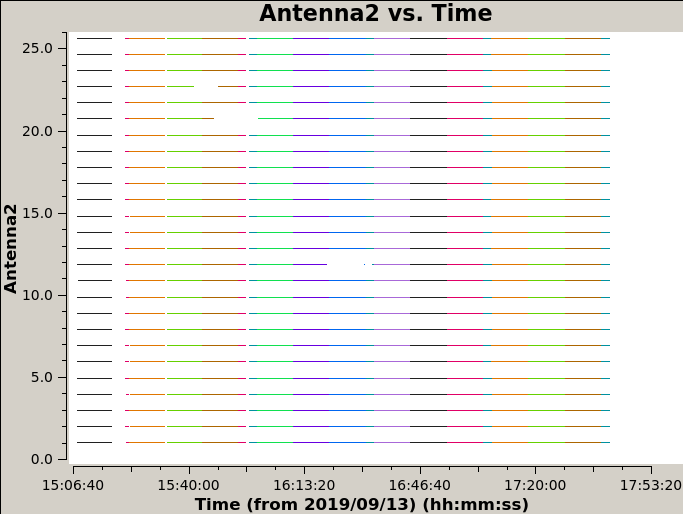

In [7]:
Image(filename=root + "/plots/obsplots/data_stream.png")

## Find Dead Antennas
Antennas that have low power should be flagged. This is also a good time to check for suitable reference antennas.

In [8]:
def plot_dead_ants(ant):
    plotfile = root + f"/plots/dataplots/find_dead_ants_amp_vs_freq_ant_{ant}.png"
    img = mpimg.imread(plotfile)
    plt.imshow(img)
    
interact(plot_dead_ants, ant=(1, 26))
    

interactive(children=(IntSlider(value=13, description='ant', max=26, min=1), Output()), _dom_classes=('widget-…

<function __main__.plot_dead_ants(ant)>

## RFI Inspection
The visibility amplitudes are first averaged across baselines and polarisation products. A modified Z-score is then computed across time as $Z_i = \frac{x_i - \mathrm{med}\{x_i\}_i}{\sigma_\mathrm{MAD}}$, 

where $\sigma_\mathrm{MAD} = \mathrm{med}\{\left|x_i - \mathrm{med}\{x_i\}_i\right|\}$ is the Median Absolute Deviation (MAD), and $x_i$ is the data (visibility amplitude) of the $i^\mathrm{th}$ integration.

The resulting Z-score is a spectrogram with dimensions of time and frequency. It can further be averaged across one of these dimensions to obtain a time series or a spectrum, which are useful for identifying broadband and persistent narrowband RFI respectively.

Use this to identify one clean channel per spectral window which will be used for the initial gain calibration.

#### Load Data

In [9]:

with h5py.File(root + f"/output/z_score_data.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

#### Plot

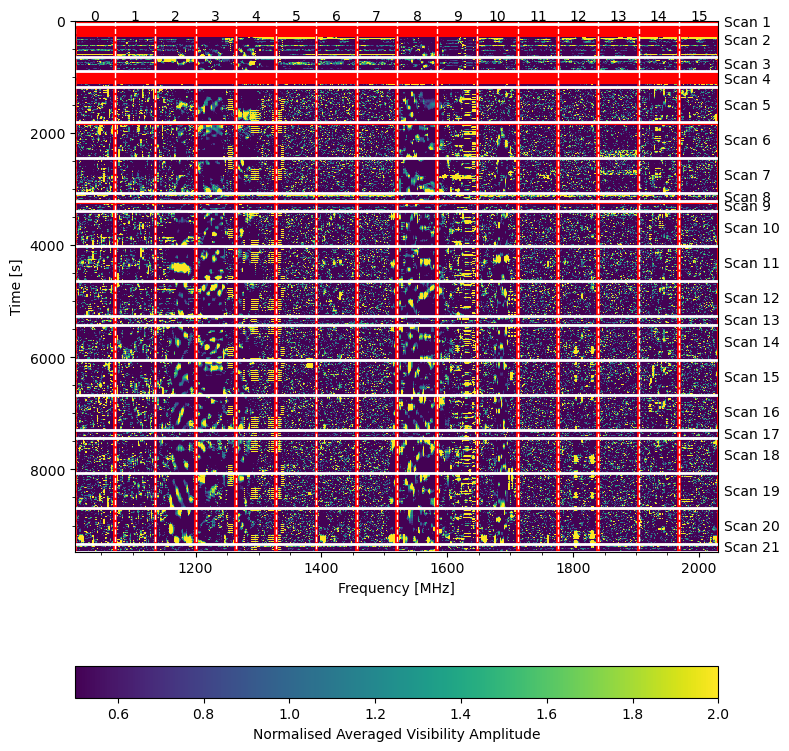

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=0.5, vmax=2, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", label="Normalised Averaged Visibility Amplitude")
plt.tight_layout()
plt.show()

In [11]:
def plot_wf_spw(i):
    inspect.plot_wf_spw(freq_array, z_score, i, 2, ntimes, plot_masked=True)
    
interact(plot_wf_spw, i=(0, 15))

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_wf_spw(i)>

In [12]:
summary_before = np.load(root + "/output/manual_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/manual_flags_summary_after.npy", allow_pickle='TRUE').item()
        
print("Flag occupancy (percent) before and after manual flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after manual flags:

field 3C147
Before: 74.1521, After: 74.1521

field J0842+1835
Before: 84.8671, After: 84.8671

field J0909+0121
Before: 66.0095, After: 66.0095

field QSO J0818+1722
Before: 59.1098, After: 59.1098

field QSO J0828+2633
Before: 57.3725, After: 57.3725

field QSO J0842+1218
Before: 59.7967, After: 59.7967

field QSO J0844+0226
Before: 56.1115, After: 56.1115

field QSO J0844-0052
Before: 55.4017, After: 55.4017

field QSO J0853+0139
Before: 58.6407, After: 58.6407

field QSO J0857+0056
Before: 55.4682, After: 55.4682

field QSO J0859+0022
Before: 54.5893, After: 54.5893

field QSO J0902+0155
Before: 54.5893, After: 54.5893

field QSO J0905+0300
Before: 54.5893, After: 54.5893

field QSO J0911+0152
Before: 54.5893, After: 54.5893

field QSO J0935-0110
Before: 55.7561, After: 55.7561

scan 1
Before: 100.0000, After: 100.0000

scan 10
Before: 56.1115, After: 56.1115

scan 11
Before: 55.4017, After: 55.4017

scan 12
Before: 58.6407, A

## Flux Calibrator Model
Print model flux densities and plot model amplitude vs. uv-distance. If the calibrator is not resolved, its amplitude should be constant across different uv-distances. If it is slightly resolved, the amplitude will decrease as a function of uv-distance.

In [13]:
setjy = np.load(root + "/output/setjy.npy", allow_pickle='TRUE').item()

print("model flux densities in Jy\n")

for spw in range(16):
    print("SPW {:2d}: I: {:.2f}, U: {:.2f}, V: {:.2f}, Q: {:.2f}".format(spw, *setjy["0"][str(spw)]["fluxd"]))

model flux densities in Jy

SPW  0: I: 28.13, U: 0.00, V: 0.00, Q: 0.00
SPW  1: I: 26.94, U: 0.00, V: 0.00, Q: 0.00
SPW  2: I: 25.85, U: 0.00, V: 0.00, Q: 0.00
SPW  3: I: 24.85, U: 0.00, V: 0.00, Q: 0.00
SPW  4: I: 23.92, U: 0.00, V: 0.00, Q: 0.00
SPW  5: I: 23.06, U: 0.00, V: 0.00, Q: 0.00
SPW  6: I: 22.27, U: 0.00, V: 0.00, Q: 0.00
SPW  7: I: 21.52, U: 0.00, V: 0.00, Q: 0.00
SPW  8: I: 20.83, U: 0.00, V: 0.00, Q: 0.00
SPW  9: I: 20.18, U: 0.00, V: 0.00, Q: 0.00
SPW 10: I: 19.57, U: 0.00, V: 0.00, Q: 0.00
SPW 11: I: 19.00, U: 0.00, V: 0.00, Q: 0.00
SPW 12: I: 18.46, U: 0.00, V: 0.00, Q: 0.00
SPW 13: I: 17.95, U: 0.00, V: 0.00, Q: 0.00
SPW 14: I: 17.47, U: 0.00, V: 0.00, Q: 0.00
SPW 15: I: 17.02, U: 0.00, V: 0.00, Q: 0.00


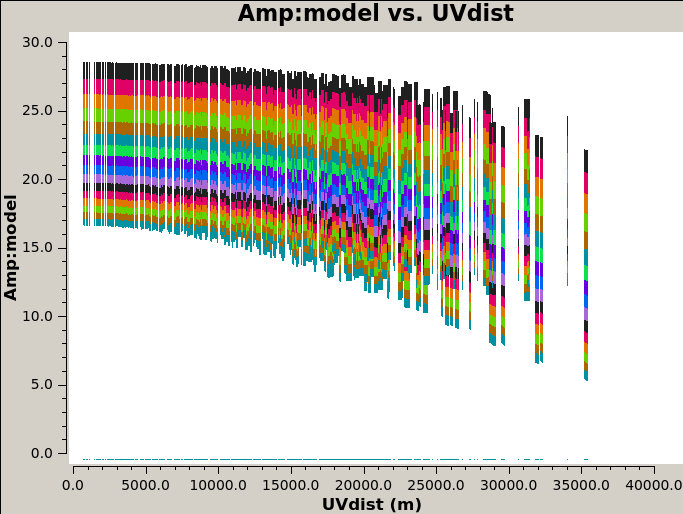

In [14]:
Image(filename=root + "/plots/calplots/setjy_model_amp_vs_uvdist.png")

## Prior Calibration

The prior calibration includes atmospheric opacity corrections, antenna offset corrections and requantizer (rq) gains. These are independent of calibrator observations and use external data instead.

### Weather
Plot weather data and print opacities. For frequencies below 10 GHz the opacity is negligibly small.  

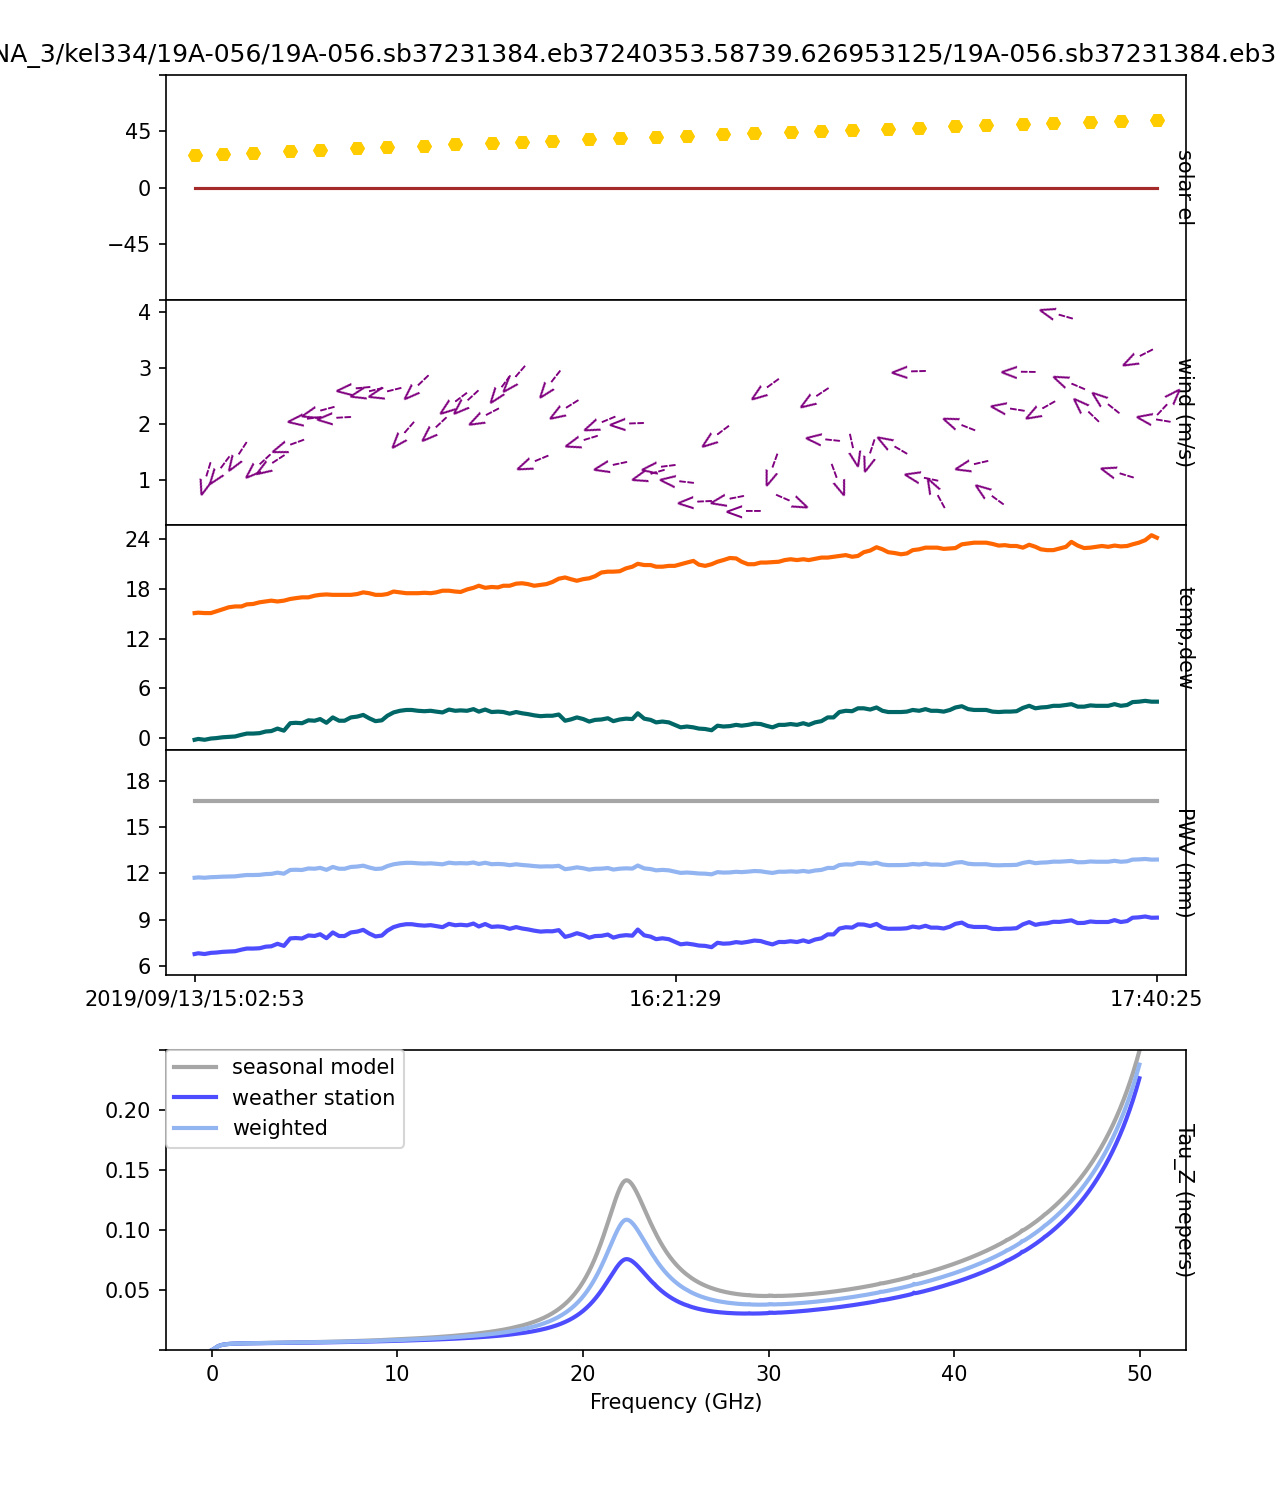

In [15]:
Image(filename=root + "/plots/calplots/weather.png")

In [16]:
opacities = np.load(root + "/output/weather.npy")

print("Opacities [Nepers]\n")

for spw, opacity in enumerate(opacities):
    print(f"SPW {spw}: {opacity}")

Opacities [Nepers]

SPW 0: 0.0051562880578127435
SPW 1: 0.005216064683295563
SPW 2: 0.005268027348569672
SPW 3: 0.0053134006182501935
SPW 4: 0.005353625687928043
SPW 5: 0.005389298648643443
SPW 6: 0.005421353334117604
SPW 7: 0.005450263904965188
SPW 8: 0.0054765607885954365
SPW 9: 0.005500651490611646
SPW 10: 0.005522825961959133
SPW 11: 0.005543432811022248
SPW 12: 0.005562619049608185
SPW 13: 0.0055806663468495
SPW 14: 0.005597683941699199
SPW 15: 0.005613851617430017


## Plot Calibration Channels
These are the channels that have been selected for the gain calibration. They should be clean and should not exhibit any amplitude jumps.

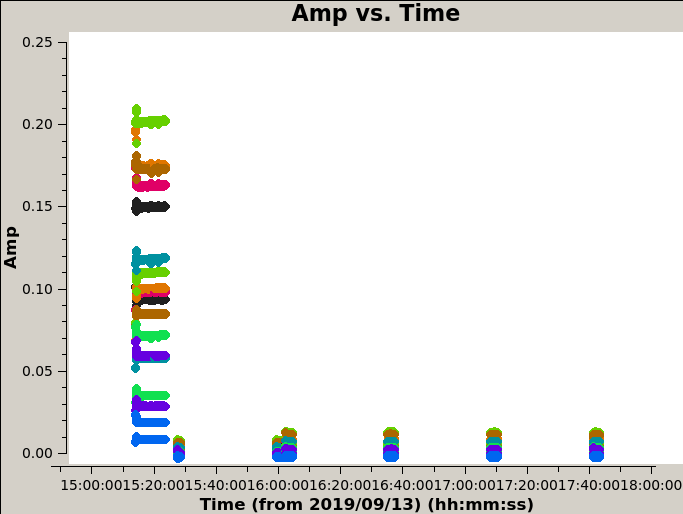

In [17]:
Image(filename=root + "/plots/dataplots/single_chans_amp_vs_time.png")

## Initial Calibration
The initial calibration is done to enable subsequent flagging with automated flagging routines such as CASA's RFlag. The calibration consists of an initial gain phase calibration, a delay calibration, an initial gain phase and amplitude calibration and a bandpass calibration. The two gain calibrations are used for the delay and bandpass calibrations, but are not applied to the data. The gain calibrations are done with a single channel per spectral window.

In [18]:
def plot_two_cols(im1, im2):
    """ 
    Plot two image side by side. E.g phase and amplitude.
    """
    fix, ax = plt.subplots(1, 2, figsize=(15, 5))

    if os.path.exists(im1):
        img_1 = mpimg.imread(im1)
        ax[0].imshow(img_1)

    if os.path.exists(im2):
        img_2 = mpimg.imread(im2)
        ax[1].imshow(img_2)

### Specify Gain Tables

In [19]:
# specify calibration table names
rnd = 0
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration
This is an initial per-integration phase calibration and is done to avoid decorrelation under temporal averaging in the subsequent delay calibration. The gain phase should be stable in time. Antennas or spectral windows that have gain phase discontinuities should be flagged. If all but the reference antenna exhibit phase jumps, a difference reference antenna should be chosen.

In [20]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration
The delay calibration is done by fitting for the phase slopes across frequency with respect to the reference antenna. The first and last 15 channels of the spectral windows are not used in this step, since they have lower gains. The delays should lie between -5 and 5 ns, and anything outside that range should be treated with suspicion.

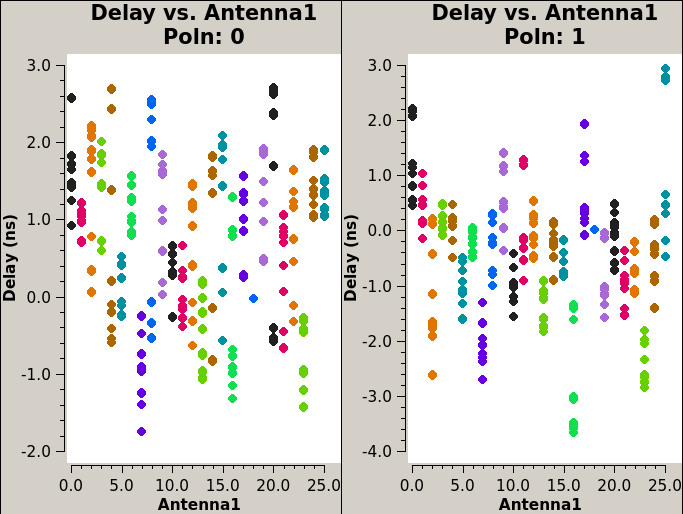

In [21]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration
Similarly to above, we perform an initial gain calibration for the bandpass calibration, but this time we also solve for the amplitudes. The phases and amplitudes should be constant with time and discontinuous solutions should be flagged.

In [22]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration
The amplitudes and phases of the bandpass calibration should be close to 1 and zero respectively after the initial gain calibration. Discontinuities should be flagged.

In [23]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [24]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Plot Corrected Data
This data is averaged in time and colorised by antenna.

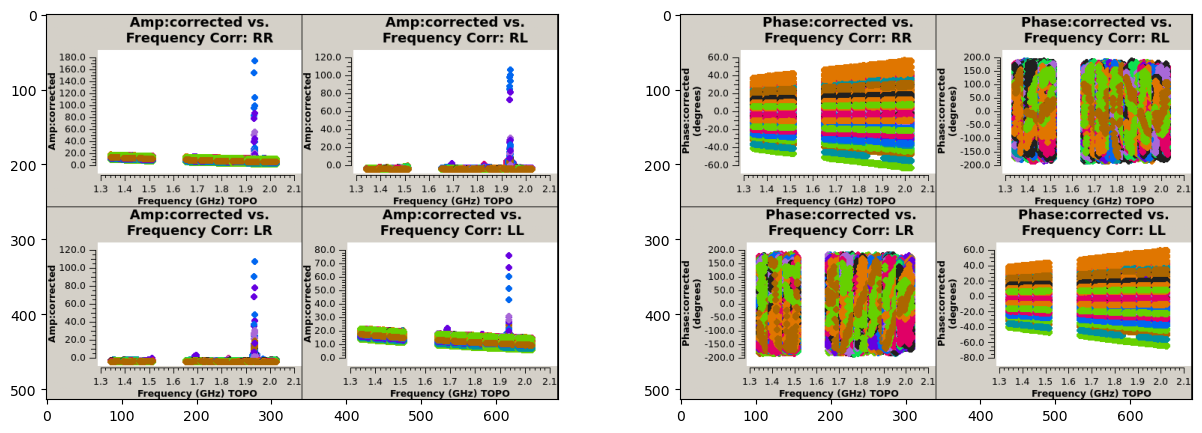

In [25]:
plot_two_cols(
    root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_CorrRR,RL,LR,LL.png",
    root + f"/plots/dataplots/fluxcal_initcal_round_0_phase_vs_freq_CorrRR,RL,LR,LL.png"
)

#### Plot Averaged Corrected Data
Iterate through spectral windows to identify RFI and flag bad channels manually below.

In [26]:
def plot_corrected_spw(spw):
    img = mpimg.imread(root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_avg_spw_{spw}_CorrRR,RL,LR,LL.png")
    plt.imshow(img)

interact(plot_corrected_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_corrected_spw(spw)>

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [27]:
rnd=0
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 0:

field 3C147
Before: 50.8188, After: 74.1521

antenna ea01
Before: 50.0931, After: 72.9867

antenna ea02
Before: 50.1014, After: 72.9867

antenna ea03
Before: 50.0931, After: 72.9867

antenna ea04
Before: 50.0931, After: 72.9867

antenna ea05
Before: 50.0931, After: 72.9867

antenna ea06
Before: 50.1014, After: 72.9867

antenna ea07
Before: 50.0931, After: 72.9867

antenna ea08
Before: 50.0931, After: 72.9867

antenna ea09
Before: 50.0931, After: 72.9867

antenna ea10
Before: 50.1014, After: 72.9867

antenna ea11
Before: 50.0931, After: 72.9867

antenna ea12
Before: 50.0931, After: 72.9867

antenna ea13
Before: 50.0931, After: 72.9867

antenna ea14
Before: 51.8221, After: 73.9177

antenna ea15
Before: 50.0931, After: 72.9867

antenna ea16
Before: 53.0443, After: 75.9380

antenna ea17
Before: 50.0931, After: 72.9867

antenna ea18
Before: 50.3477, After: 73.3093

antenna ea19
Before: 50.0931, After: 72.9867

antenna e

## First Round of Flagging on Primary Calibrator
The first round of flagging is performed on the primary calibrator only. The flagging routine runs RFlag with timedevscale=5.0, freqdevscale=5.0 and freqfit=line on a ABS_RL, ABS_LR, ABS_LL, ABS_RR, REAL_LL, REAL_RR, IMAG_LL and IMAG_RR, where for the real and imaginary parts RFLag is performed on the residual (corrected-model) data. TFCrop is run with timecutoff=4.0 and freqcutoff=4.0 on ABS_RL, ABS_LR, ABS_LL and ABS_RR. Flags are extended across polarisations. The plots below show the amplitudes and phases of the calibrators before and after flagging respectively.

### Before Flagging

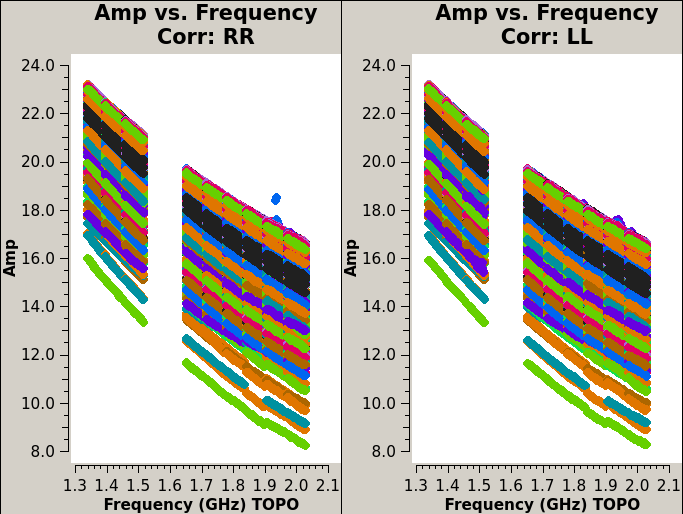

In [28]:
Image(filename=root + "/plots/dataplots/before_fluxcal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

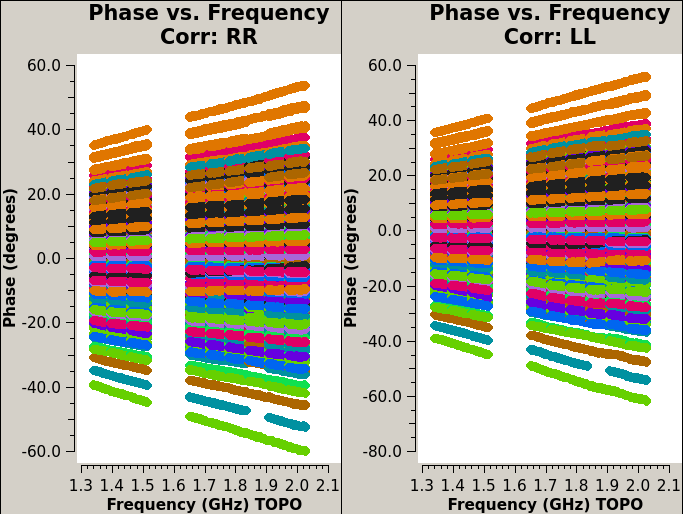

In [29]:
Image(filename=root + "/plots/dataplots/before_fluxcal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

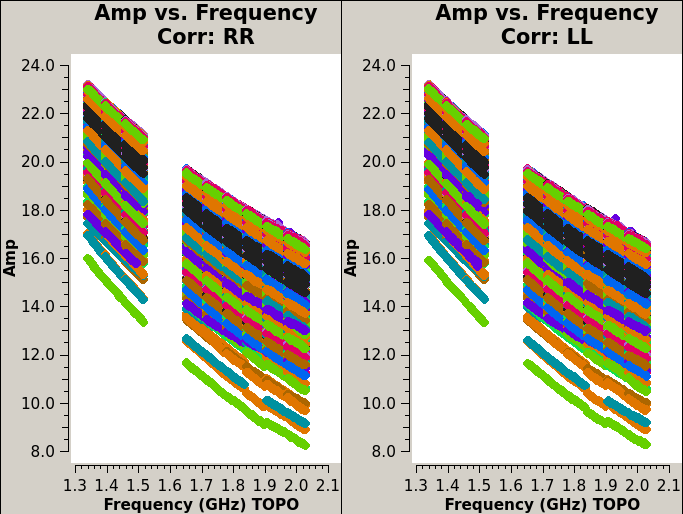

In [30]:
Image(filename=root + "/plots/dataplots/after_fluxcal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

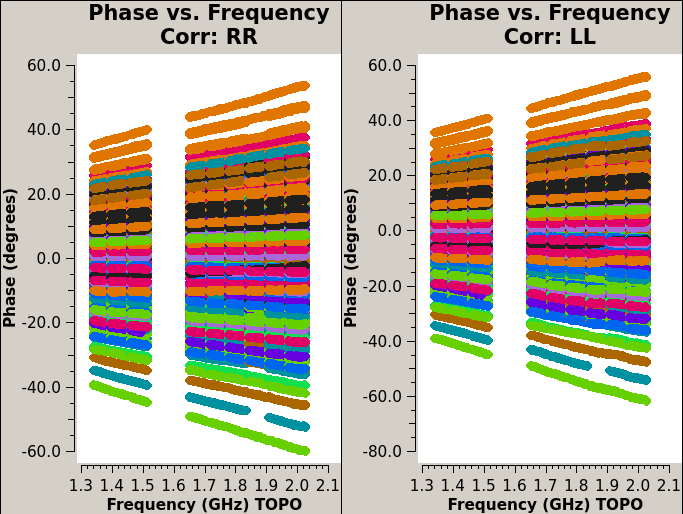

In [31]:
Image(filename=root + "/plots/dataplots/after_fluxcal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### Summary

In [32]:
summary_before = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the flux calibrator:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the flux calibrator:

field 3C147
Before: 74.1521, After: 74.3177

antenna ea01
Before: 72.9867, After: 73.1241

antenna ea02
Before: 72.9867, After: 73.0686

antenna ea03
Before: 72.9867, After: 73.0556

antenna ea04
Before: 72.9867, After: 73.0730

antenna ea05
Before: 72.9867, After: 73.0418

antenna ea06
Before: 72.9867, After: 73.0730

antenna ea07
Before: 72.9867, After: 73.0572

antenna ea08
Before: 72.9867, After: 73.1899

antenna ea09
Before: 72.9867, After: 73.2043

antenna ea10
Before: 72.9867, After: 73.1585

antenna ea11
Before: 72.9867, After: 73.0983

antenna ea12
Before: 72.9867, After: 73.1138

antenna ea13
Before: 72.9867, After: 73.0574

antenna ea14
Before: 73.9177, After: 73.9840

antenna ea15
Before: 72.9867, After: 73.0889

antenna ea16
Before: 75.9380, After: 75.9961

antenna ea17
Before: 72.9867, After: 73.1323

antenna ea18
Before: 73.3093, After: 74.7749

antenna ea19
Before: 72.9867, After: 73.0901

antenna 

## Semi-Final Calibration
The steps from the intitial calibration are repeated. 

### Specify Gain Tables

In [72]:
# specify calibration table names
rnd = 1
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration

In [73]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

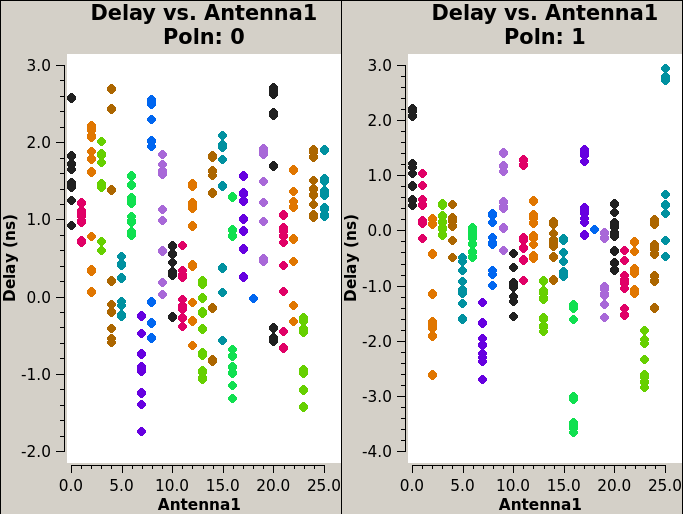

In [74]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [75]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration

In [37]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [38]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [39]:
rnd=1
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 1:

field 3C147
Before: 74.3177, After: 74.3180

antenna ea01
Before: 73.1241, After: 73.1246

antenna ea02
Before: 73.0686, After: 73.0686

antenna ea03
Before: 73.0556, After: 73.0556

antenna ea04
Before: 73.0730, After: 73.0731

antenna ea05
Before: 73.0418, After: 73.0423

antenna ea06
Before: 73.0730, After: 73.0732

antenna ea07
Before: 73.0572, After: 73.0583

antenna ea08
Before: 73.1899, After: 73.1899

antenna ea09
Before: 73.2043, After: 73.2049

antenna ea10
Before: 73.1585, After: 73.1585

antenna ea11
Before: 73.0983, After: 73.0986

antenna ea12
Before: 73.1138, After: 73.1140

antenna ea13
Before: 73.0574, After: 73.0574

antenna ea14
Before: 73.9840, After: 73.9840

antenna ea15
Before: 73.0889, After: 73.0891

antenna ea16
Before: 75.9961, After: 75.9961

antenna ea17
Before: 73.1323, After: 73.1327

antenna ea18
Before: 74.7749, After: 74.7792

antenna ea19
Before: 73.0901, After: 73.0901

antenna e

## Second Round of Flagging
The flagging is repeated, but this time on all calibrators.

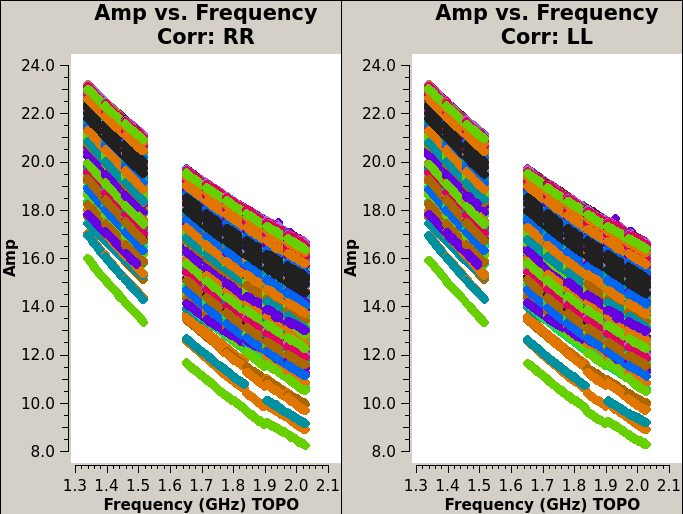

In [40]:
# primary calibrator
Image(filename=root + "/plots/dataplots/before_fluxcal_round_1_flagging_amp_vs_freq_CorrRR,LL.png")

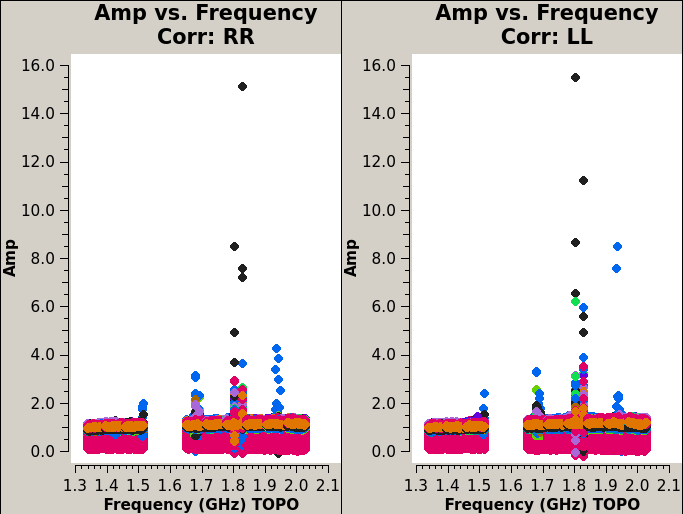

In [41]:
# phase calibrators
Image(filename=root + "/plots/dataplots/before_phasecal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

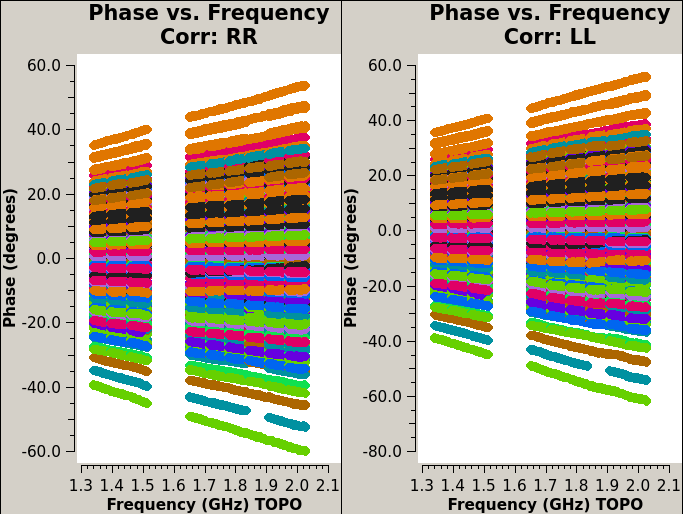

In [42]:
# primary calibrator
Image(filename=root + "/plots/dataplots/before_fluxcal_round_1_flagging_phase_vs_freq_CorrRR,LL.png")

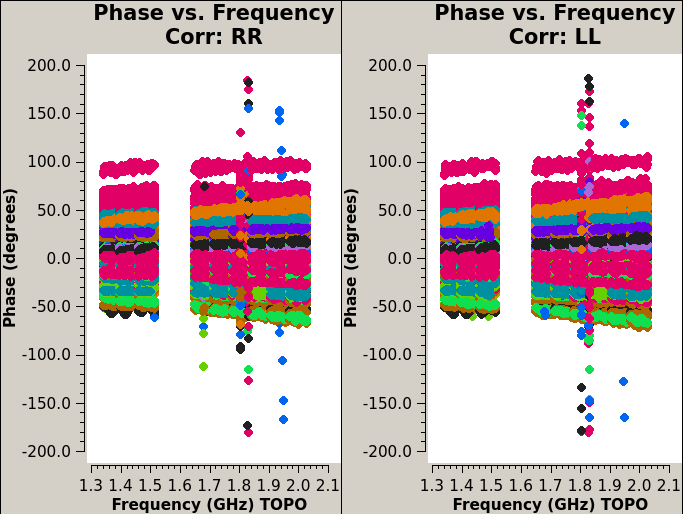

In [43]:
# phase calibrators
Image(filename=root + "/plots/dataplots/before_phasecal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

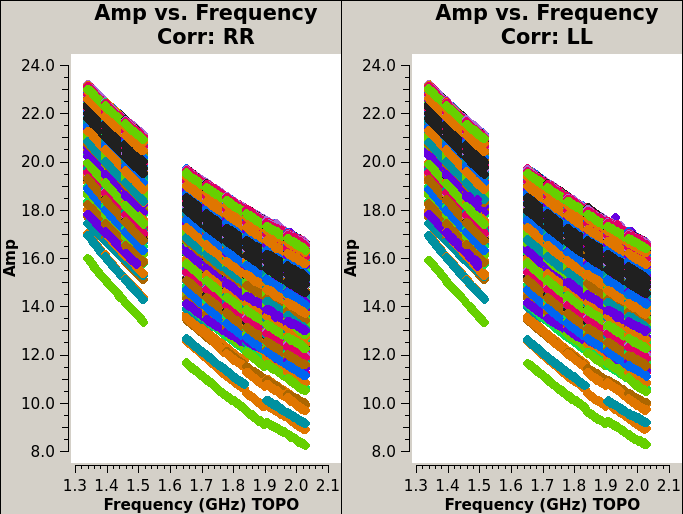

In [44]:
# primary calibrator
Image(filename=root + "/plots/dataplots/after_fluxcal_round_1_flagging_amp_vs_freq_CorrRR,LL.png")

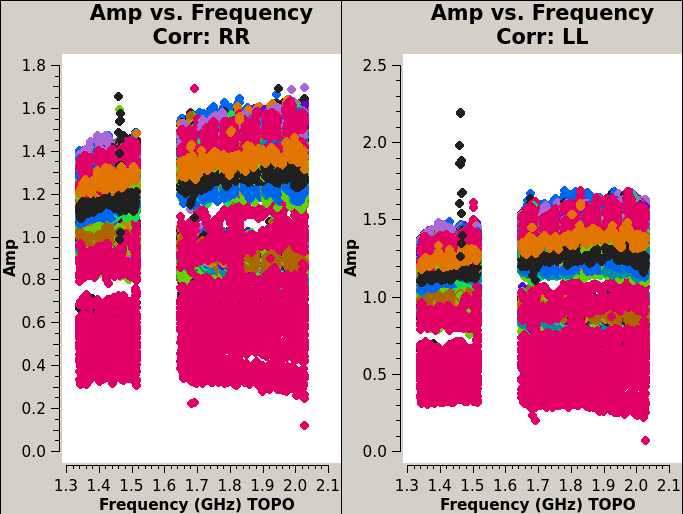

In [45]:
# phase calibrators
Image(filename=root + "/plots/dataplots/after_phasecal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

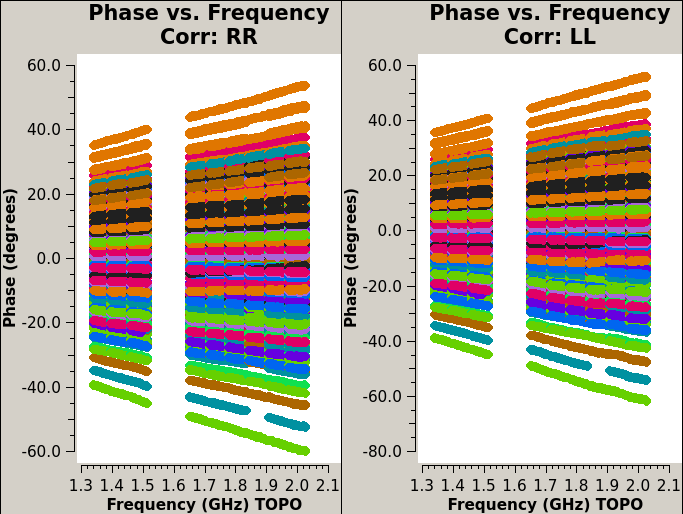

In [46]:
# primary calibrator
Image(filename=root + "/plots/dataplots/after_fluxcal_round_1_flagging_phase_vs_freq_CorrRR,LL.png")

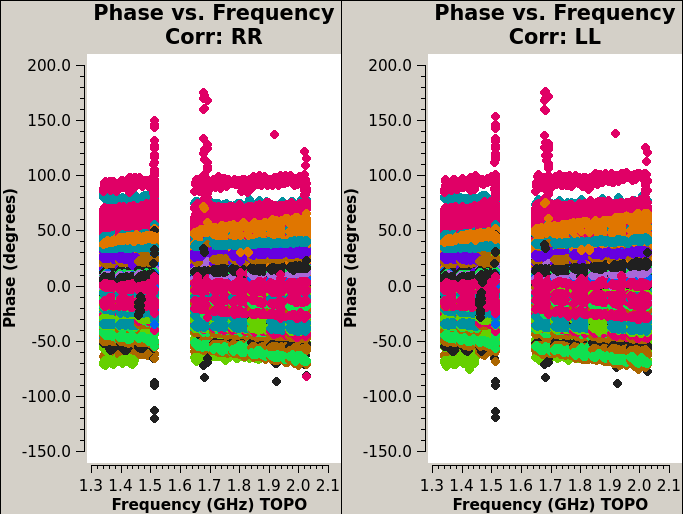

In [47]:
# phase calibrators
Image(filename=root + "/plots/dataplots/after_phasecal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### Flagging Summary

In [48]:
summary_before = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the flux calibrator:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the flux calibrator:

field 3C147
Before: 74.3180, After: 74.3993

scan 1
Before: 100.0000, After: 100.0000

scan 2
Before: 77.7023, After: 77.7780

scan 3
Before: 60.2033, After: 60.3164

antenna ea01
Before: 73.1246, After: 73.1812

antenna ea02
Before: 73.0686, After: 73.1220

antenna ea03
Before: 73.0556, After: 73.1242

antenna ea04
Before: 73.0731, After: 73.1430

antenna ea05
Before: 73.0423, After: 73.0968

antenna ea06
Before: 73.0732, After: 73.1596

antenna ea07
Before: 73.0583, After: 73.1572

antenna ea08
Before: 73.1899, After: 73.2810

antenna ea09
Before: 73.2049, After: 73.2838

antenna ea10
Before: 73.1585, After: 73.2572

antenna ea11
Before: 73.0986, After: 73.1706

antenna ea12
Before: 73.1140, After: 73.2451

antenna ea13
Before: 73.0574, After: 73.1199

antenna ea14
Before: 73.9840, After: 74.0413

antenna ea15
Before: 73.0891, After: 73.1891

antenna ea16
Before: 75.9961, After: 76.0428

antenna ea17
Before: 73.

In [49]:
summary_before = np.load(root + f"/output/phasecal_round_0_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/phasecal_round_0_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the phase calibrators:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the phase calibrators:

field J0842+1835
Before: 84.9078, After: 89.9635

field J0909+0121
Before: 66.0986, After: 67.2823

scan 13
Before: 62.7443, After: 64.6593

scan 17
Before: 63.5381, After: 64.4080

scan 21
Before: 64.2915, After: 65.4471

scan 4
Before: 92.7063, After: 100.0000

scan 8
Before: 69.2054, After: 69.7549

scan 9
Before: 72.4989, After: 73.3584

antenna ea01
Before: 72.2267, After: 74.9150

antenna ea02
Before: 72.6029, After: 74.8920

antenna ea03
Before: 72.1729, After: 74.7890

antenna ea04
Before: 72.1729, After: 75.2062

antenna ea05
Before: 72.6029, After: 74.8170

antenna ea06
Before: 72.2948, After: 75.0100

antenna ea07
Before: 72.2267, After: 74.8043

antenna ea08
Before: 72.2267, After: 75.1096

antenna ea09
Before: 72.1729, After: 75.4852

antenna ea10
Before: 72.3664, After: 75.3144

antenna ea11
Before: 72.4416, After: 75.3575

antenna ea12
Before: 72.5205, After: 75.1359

antenna ea13
Before: 76.3250,

## Final Calibration
First, the initial calibration (delay and bandpass) are repeated on the primary calibrator. Then, the final gains of the calibrators are derived.

### Specify Gain Tables

In [50]:
# specify calibration table names
rnd = 2
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

fluxcal_phase_table = f"{name}_fluxcal_phase.Gfinal"
short_gain_table = f"{name}_short.Gfinal"
amp_gain_table = f"{name}_amp.Gfinal"
phase_gain_table = f"{name}_phase.Gfinal"

### Delay Initial Gain Calibration

In [51]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

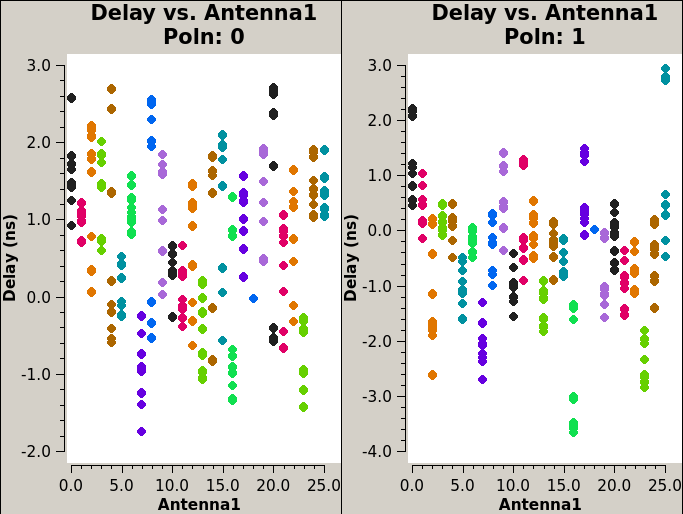

In [52]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [53]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration

In [54]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [55]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Flux Calibrator Final Gain Phase

In [56]:
def plot_final_fluxcal_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{fluxcal_phase_table}_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_fluxcal_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_fluxcal_phase(ant)>

### Short Interval Gain Calibration
This is an initial calibration done on a per-integration basis on the calibrators.

In [57]:
def plot_final_short_gain_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{short_gain_table}_phase_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_short_gain_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_short_gain_phase(ant)>

### Long Interval Gain Calibration
The gain amplitudes of the calibrators of solved for using the initial gain phase calibration above.

In [58]:
def plot_final_long_gain(ant):
    plot_two_cols(
        root + f'/plots/calplots/{amp_gain_table}_amp_ant_{ant}_Poln0,1.png',
        root + f'/plots/calplots/{amp_gain_table}_phase_ant_{ant}_Poln0,1.png'
    )

interact(plot_final_long_gain, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_long_gain(ant)>

### Phase Calibration
Derive the final gain phases of the calibrators. That of the primary calibrator should be close to zero, since it was already derived and applied earlier on.

In [59]:
def plot_final_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{phase_gain_table}_phase_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_phase(ant)>

### Flagging Summary

In [60]:
rnd=1
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after final delay and bandpass calibration:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after final delay and bandpass calibration:

field 3C147
Before: 74.3177, After: 74.3180

antenna ea01
Before: 73.1241, After: 73.1246

antenna ea02
Before: 73.0686, After: 73.0686

antenna ea03
Before: 73.0556, After: 73.0556

antenna ea04
Before: 73.0730, After: 73.0731

antenna ea05
Before: 73.0418, After: 73.0423

antenna ea06
Before: 73.0730, After: 73.0732

antenna ea07
Before: 73.0572, After: 73.0583

antenna ea08
Before: 73.1899, After: 73.1899

antenna ea09
Before: 73.2043, After: 73.2049

antenna ea10
Before: 73.1585, After: 73.1585

antenna ea11
Before: 73.0983, After: 73.0986

antenna ea12
Before: 73.1138, After: 73.1140

antenna ea13
Before: 73.0574, After: 73.0574

antenna ea14
Before: 73.9840, After: 73.9840

antenna ea15
Before: 73.0889, After: 73.0891

antenna ea16
Before: 75.9961, After: 75.9961

antenna ea17
Before: 73.1323, After: 73.1327

antenna ea18
Before: 74.7749, After: 74.7792

antenna ea19
Before: 73.0901, After: 73.0901



In [61]:
summary_before = np.load(root + f"/output/applycal_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/applycal_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after applying final calibration:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after applying final calibration:

field 3C147
Before: 74.3993, After: 74.8200

field J0842+1835
Before: 89.9635, After: 89.9635

field J0909+0121
Before: 67.2823, After: 68.2760

field QSO J0818+1722
Before: 59.2255, After: 62.6292

field QSO J0828+2633
Before: 57.4922, After: 61.0113

field QSO J0842+1218
Before: 59.9147, After: 61.2150

field QSO J0844+0226
Before: 56.2351, After: 62.8051

field QSO J0844-0052
Before: 55.5272, After: 62.3124

field QSO J0853+0139
Before: 58.7614, After: 62.3124

field QSO J0857+0056
Before: 55.5932, After: 59.2774

field QSO J0859+0022
Before: 54.7167, After: 58.4737

field QSO J0902+0155
Before: 54.7167, After: 58.4737

field QSO J0905+0300
Before: 54.7167, After: 54.9785

field QSO J0911+0152
Before: 54.7167, After: 54.9785

field QSO J0935-0110
Before: 55.8802, After: 56.1353

scan 1
Before: 100.0000, After: 100.0000

scan 10
Before: 56.2351, After: 62.8051

scan 11
Before: 55.5272, After: 62.3124

scan 12
Befo

## Target Flags
Now that the final calibration tables have been derived and applied to the data, the automated flagging routine is run on the target fields.

### Before Flagging

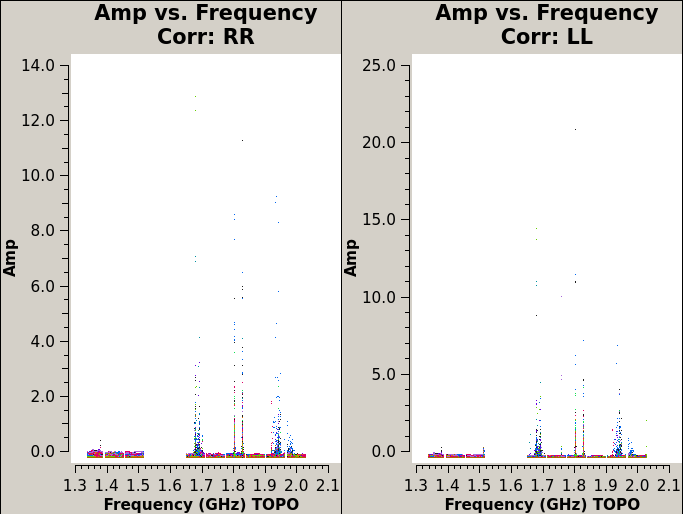

In [62]:
Image(filename=root + "/plots/dataplots/before_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

### After Flagging

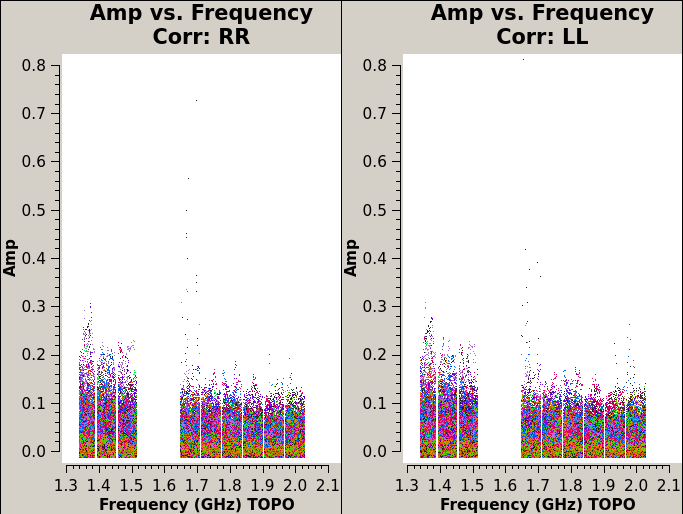

In [63]:
Image(filename=root + "/plots/dataplots/after_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

### Summary

In [64]:
rnd=0
summary_before = np.load(root + f"/output/targets_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/targets_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) after flagging the flux calibrator:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) after flagging the flux calibrator:

field QSO J0818+1722
Before: 62.6292, After: 63.1259

field QSO J0828+2633
Before: 61.0113, After: 61.4993

field QSO J0842+1218
Before: 61.2150, After: 61.8062

field QSO J0844+0226
Before: 62.8051, After: 63.7506

field QSO J0844-0052
Before: 62.3124, After: 63.7346

field QSO J0853+0139
Before: 62.3124, After: 63.2625

field QSO J0857+0056
Before: 59.2774, After: 60.2751

field QSO J0859+0022
Before: 58.4737, After: 59.4867

field QSO J0902+0155
Before: 58.4737, After: 59.2798

field QSO J0905+0300
Before: 54.9785, After: 55.9100

field QSO J0911+0152
Before: 54.9785, After: 55.9286

field QSO J0935-0110
Before: 56.1353, After: 57.6823

scan 10
Before: 62.8051, After: 63.7506

scan 11
Before: 62.3124, After: 63.7346

scan 12
Before: 62.3124, After: 63.2625

scan 14
Before: 59.2774, After: 60.2751

scan 15
Before: 58.4737, After: 59.4867

scan 16
Before: 58.4737, After: 59.2798

scan 18
Before: 54.9785, After: 55.9100

sca

## Summary Plots
These plots show the corrected amplitudes and phases of all fields as a function of uv-distance and frequency. The values plotted against uv-distance are colorised by spectral window while those plotted against frequency are colorised by antenna number. Remaining RFI should be flagged manually in CASA.

In [65]:
field_dict = vladata.get_field_names(ms)
fields = field_dict["calibrators"] + "," + field_dict["targets"]

3C147


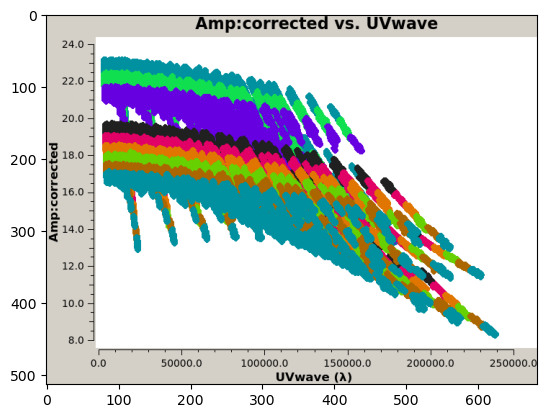

J0842+1835


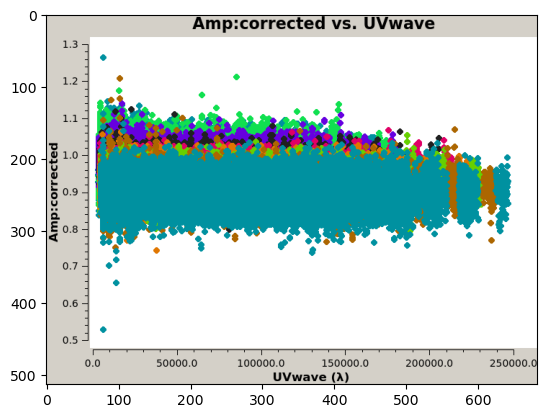

J0909+0121


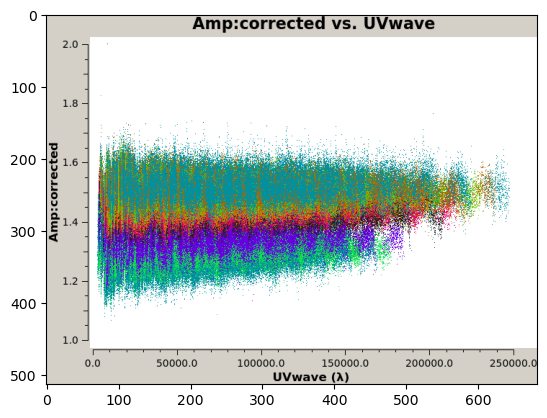

QSO J0828+2633


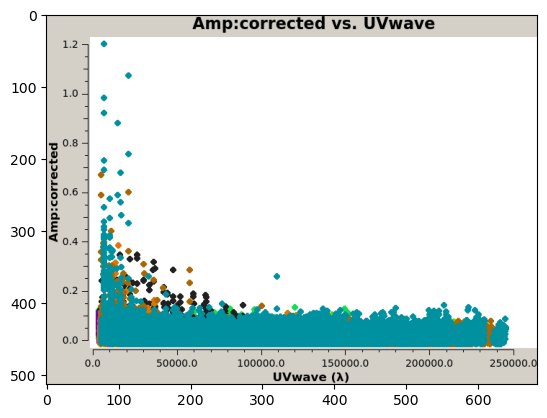

QSO J0818+1722


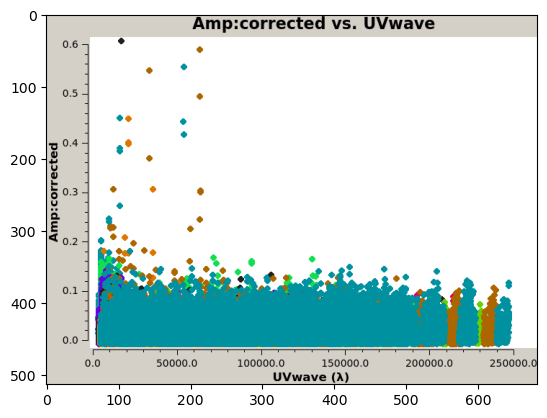

QSO J0842+1218


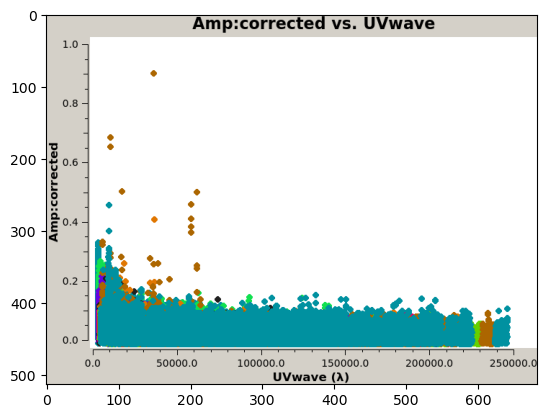

QSO J0844+0226


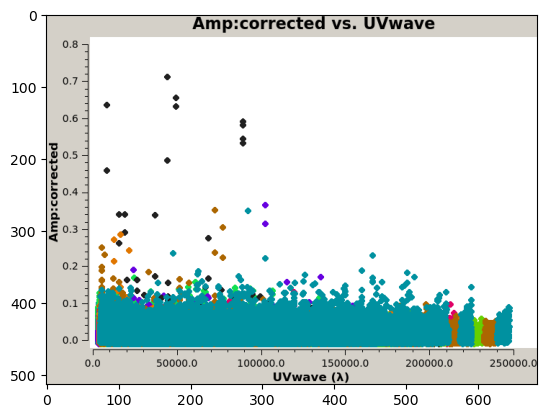

QSO J0844-0052


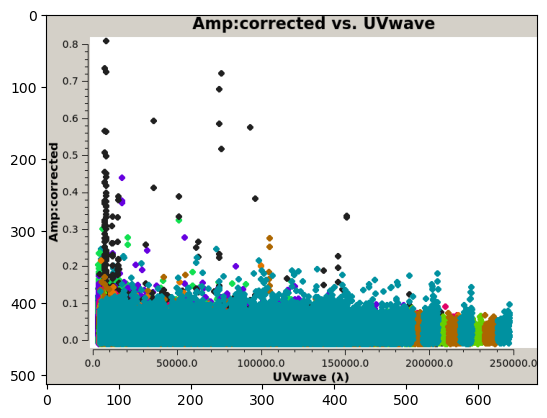

QSO J0853+0139


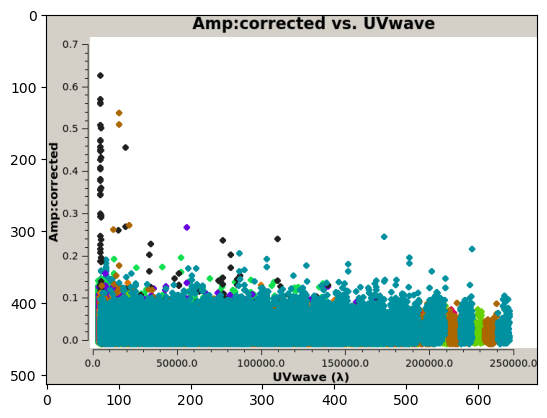

QSO J0857+0056


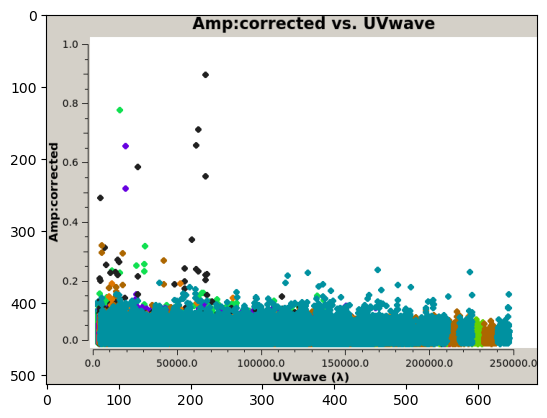

QSO J0859+0022


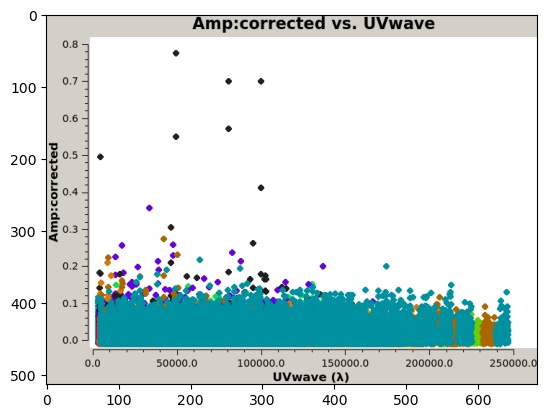

QSO J0902+0155


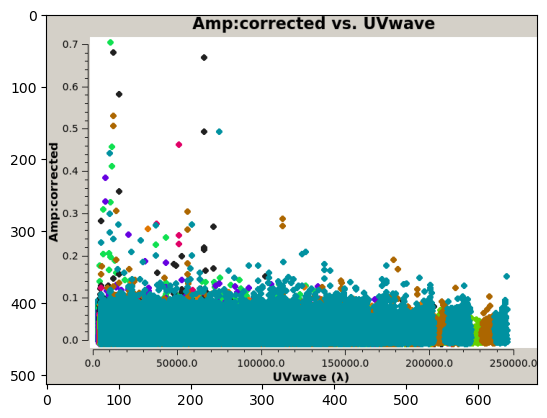

QSO J0905+0300


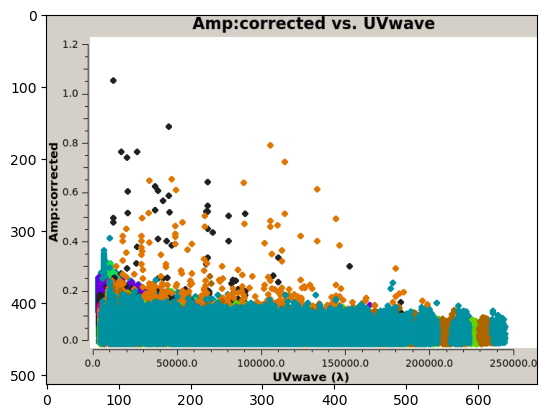

QSO J0911+0152


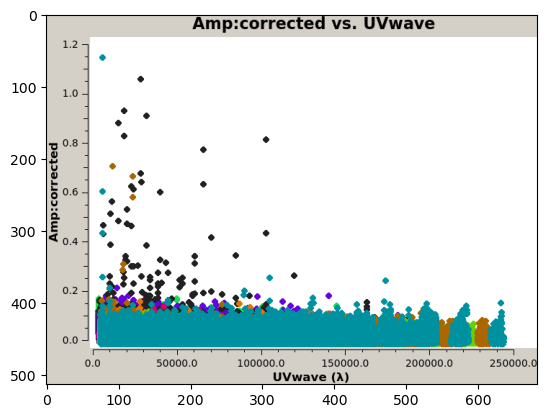

QSO J0935-0110


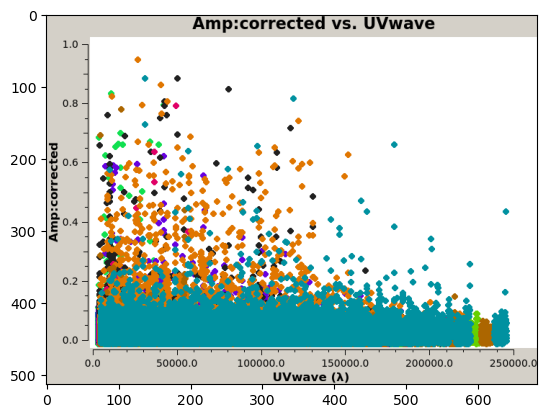

In [66]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_amp_vs_uvdist_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

3C147


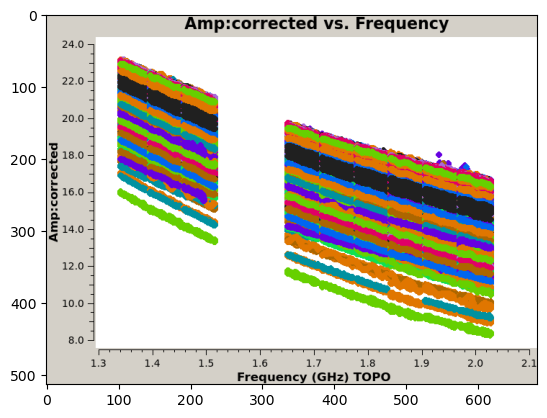

J0842+1835


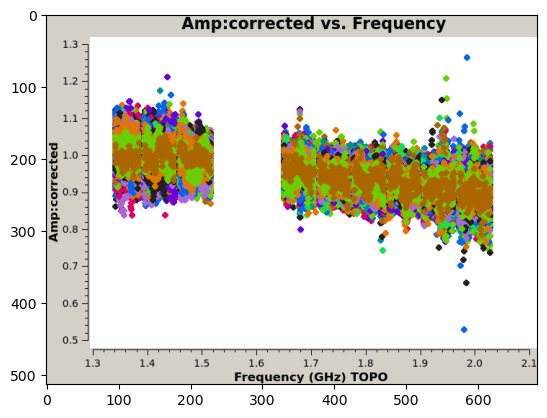

J0909+0121


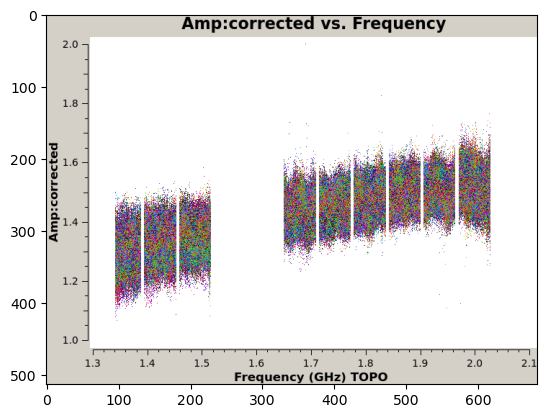

QSO J0828+2633


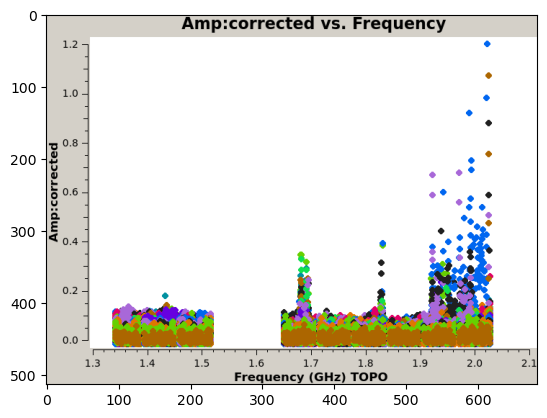

QSO J0818+1722


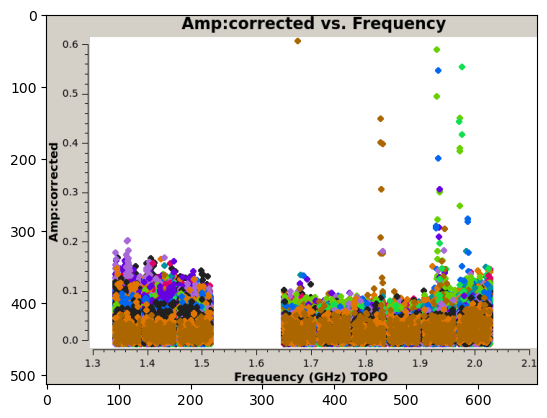

QSO J0842+1218


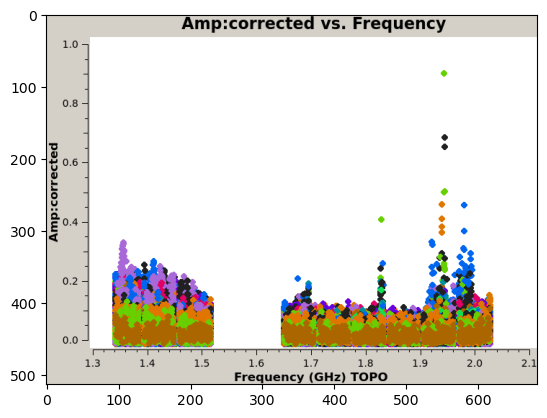

QSO J0844+0226


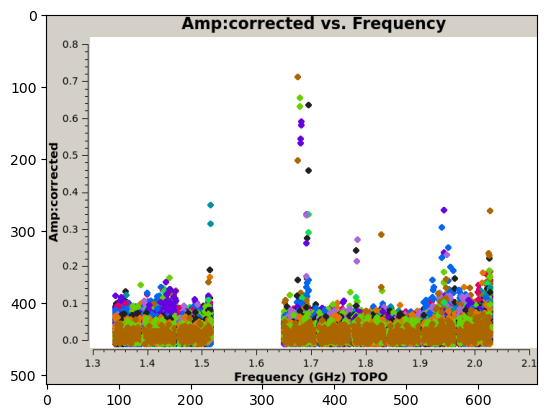

QSO J0844-0052


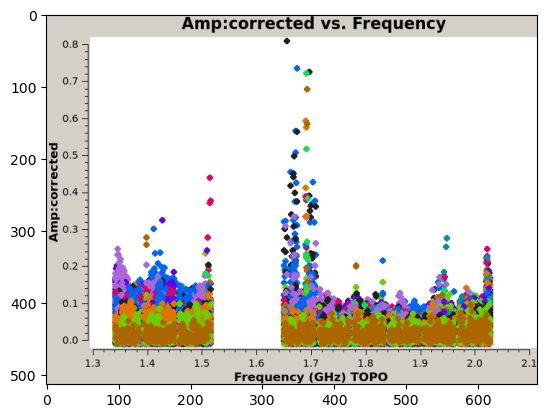

QSO J0853+0139


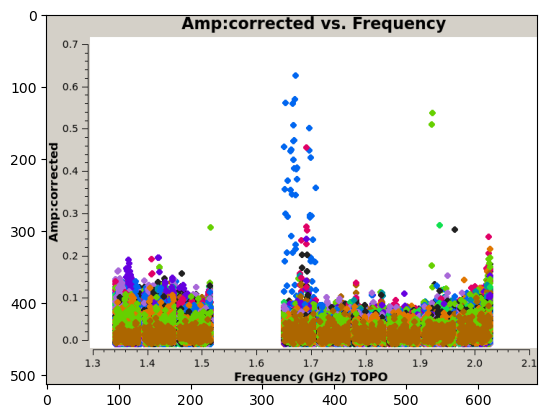

QSO J0857+0056


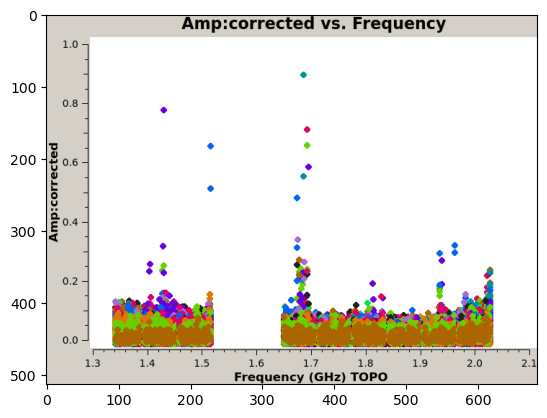

QSO J0859+0022


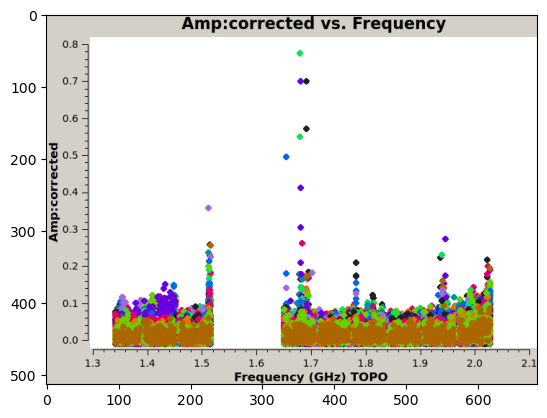

QSO J0902+0155


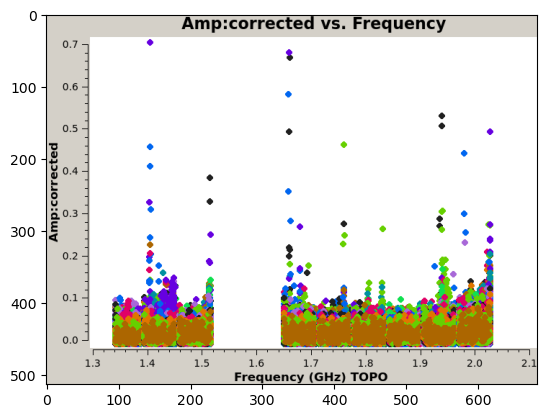

QSO J0905+0300


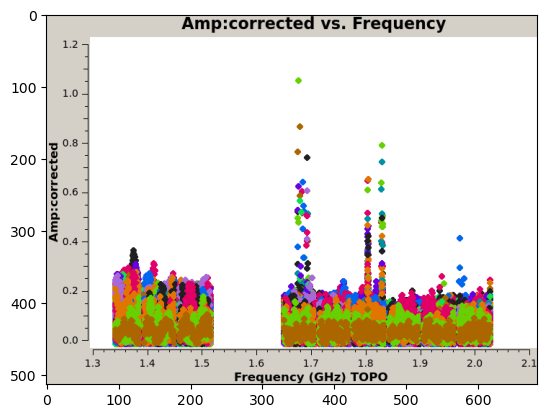

QSO J0911+0152


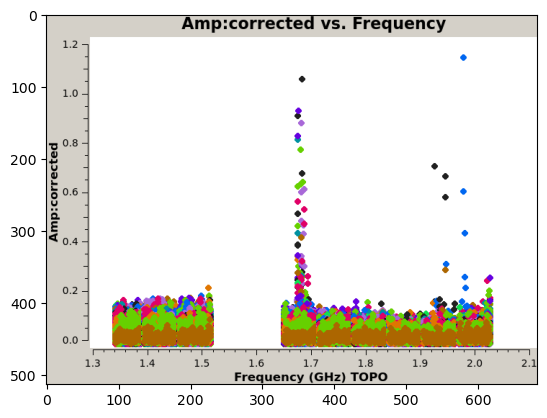

QSO J0935-0110


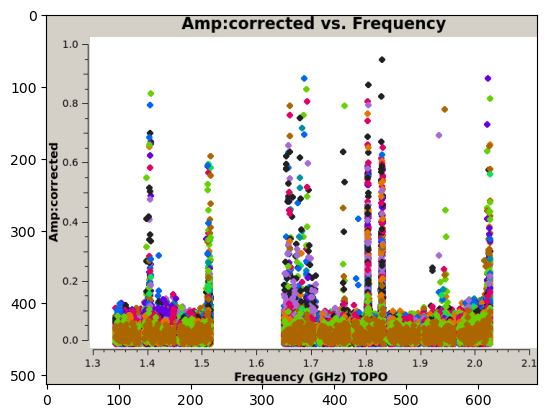

In [67]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_amp_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

3C147


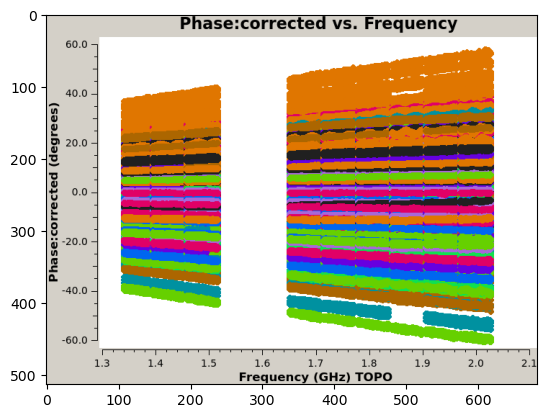

J0842+1835


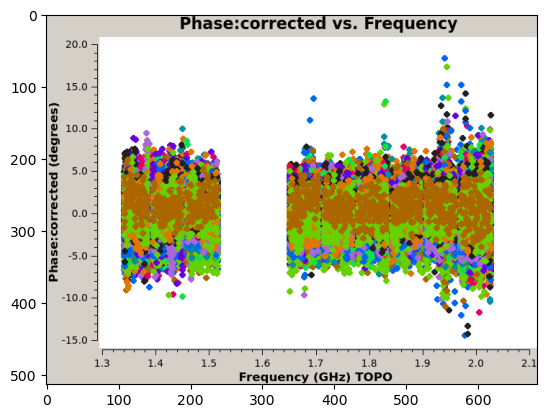

J0909+0121


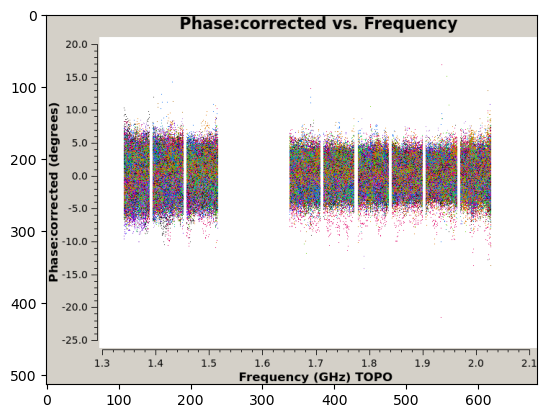

QSO J0828+2633


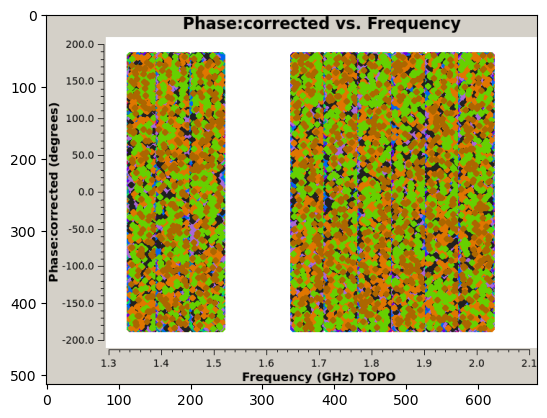

QSO J0818+1722


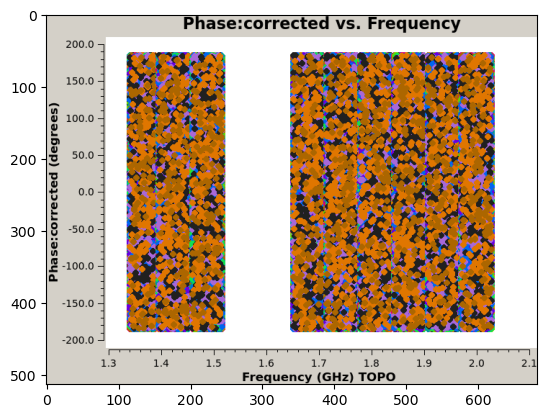

QSO J0842+1218


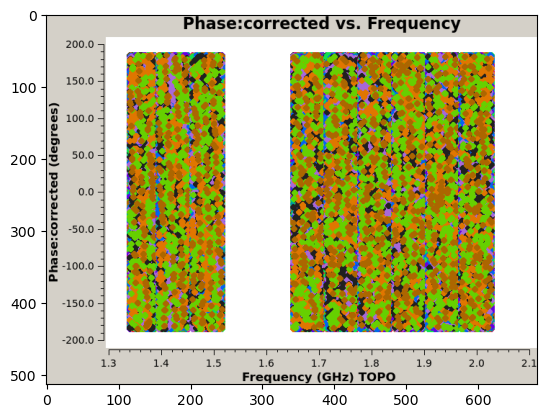

QSO J0844+0226


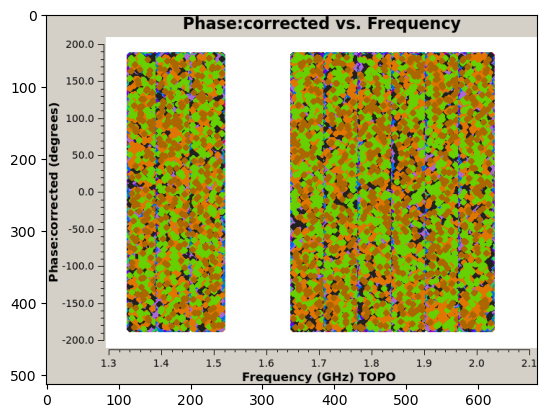

QSO J0844-0052


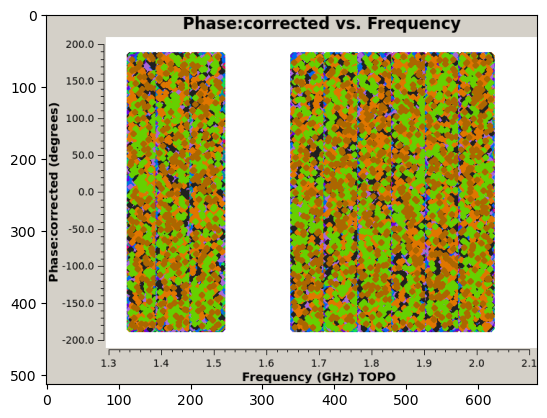

QSO J0853+0139


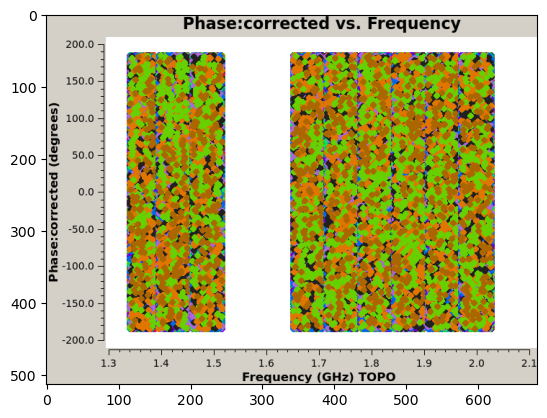

QSO J0857+0056


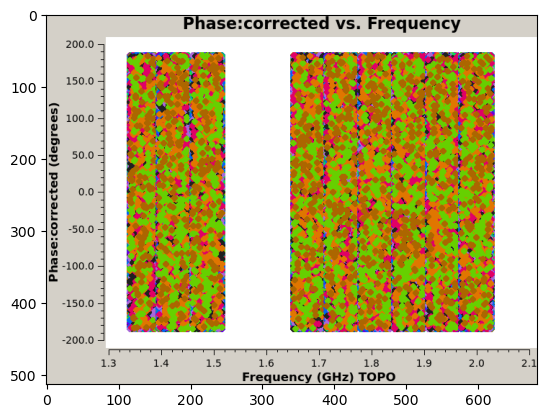

QSO J0859+0022


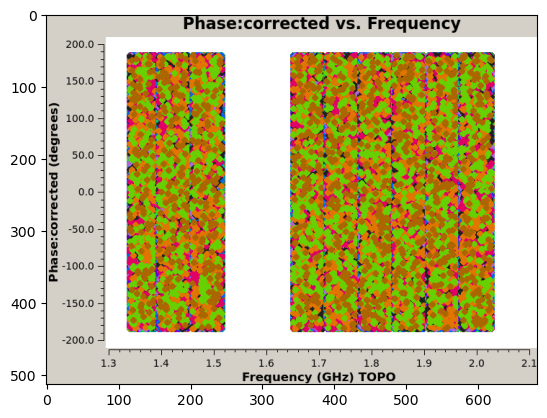

QSO J0902+0155


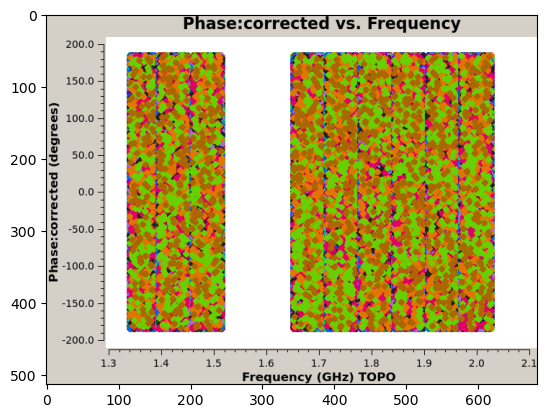

QSO J0905+0300


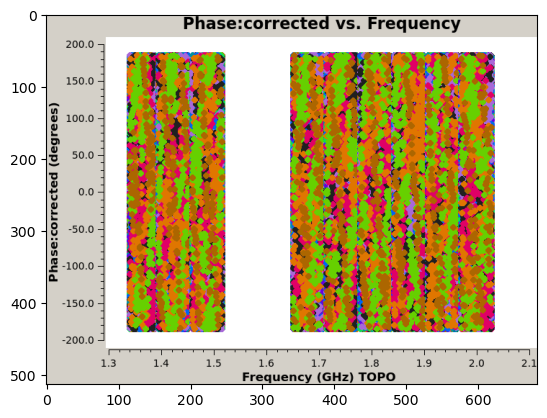

QSO J0911+0152


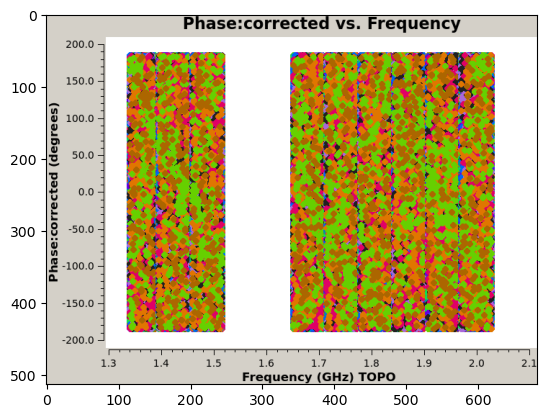

QSO J0935-0110


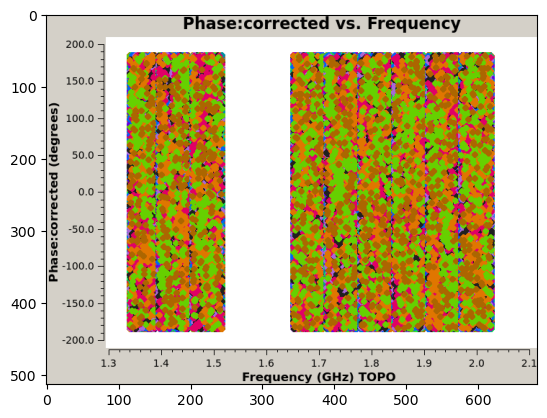

In [68]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_phase_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

In [69]:

with h5py.File(root + f"/output/z_score_corrected.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

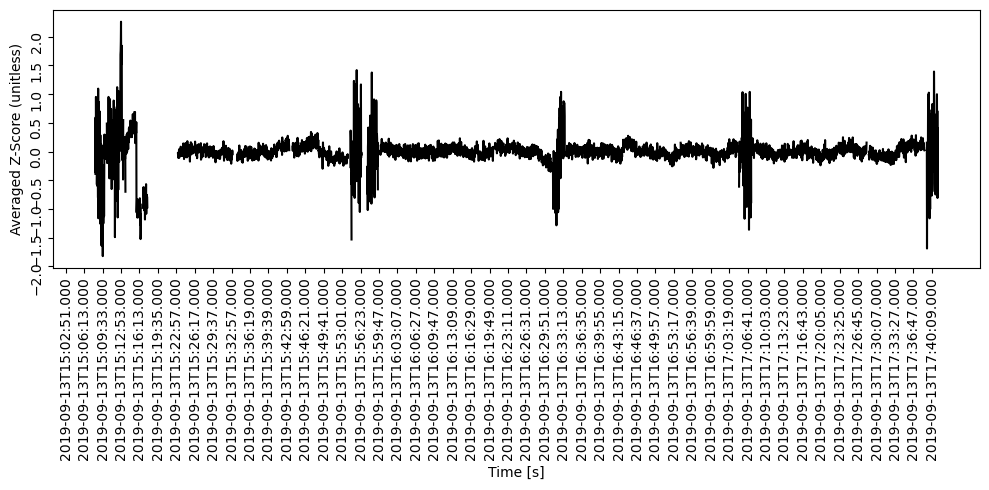

In [70]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
ax = inspect.plot_time_series(tisot, np.ma.median(z_score, axis=1), ax, plot_masked=True)
ax.set_ylabel("Averaged Z-Score (unitless)")
ax.set_xticks(tisot[::100])
plt.tight_layout()

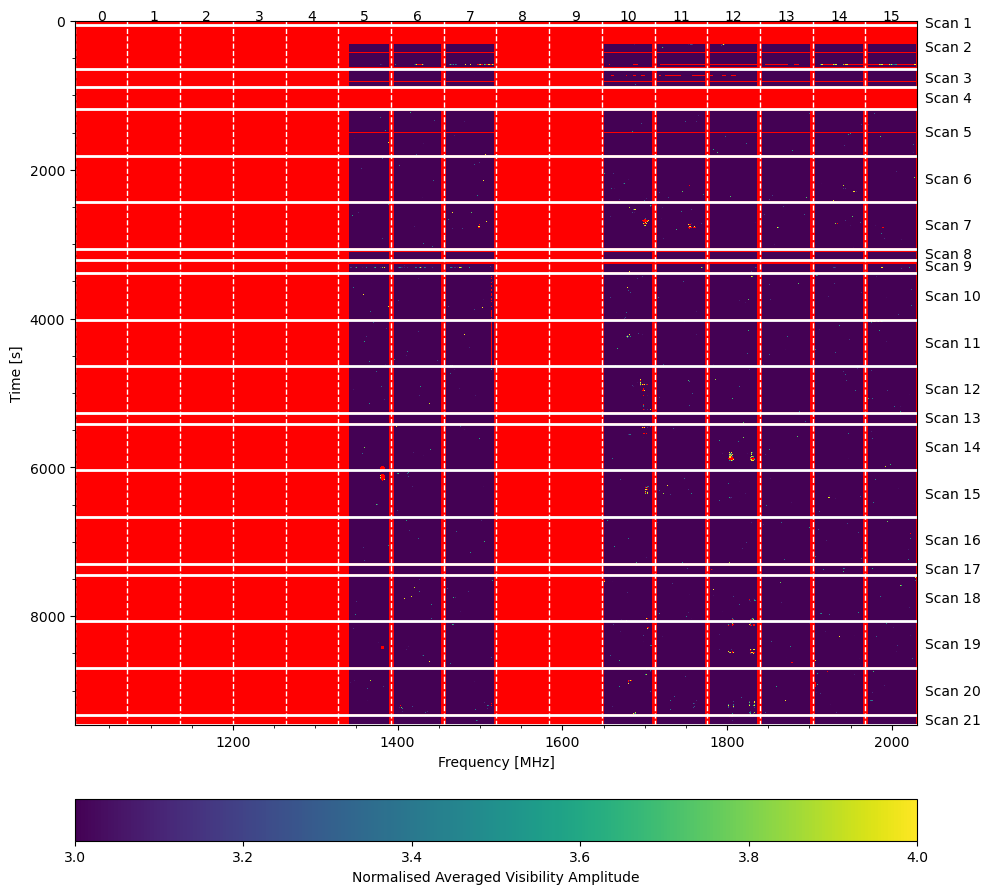

In [71]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=3, vmax=4, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", pad=0.08, label="Normalised Averaged Visibility Amplitude")